In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, auc)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


# SVM Classification: Heart Disease Prediction

## Problem Context
Cardiovascular diseases (CVDs) are the **#1 cause of death globally**, accounting for 31% of all deaths (17.9 million annually).
This notebook uses **Support Vector Machines (SVM)** to predict heart disease based on 11 clinical features.

## Learning Objectives
1. Load and explore heart disease dataset
2. Preprocess and scale features
3. Train SVM classifiers with different kernels
4. Hyperparameter tuning using GridSearchCV
5. Evaluate models with comprehensive metrics (accuracy, precision, recall, F1, ROC-AUC)
6. Compare performance and visualize results

## Dataset Information
**Target:** Heart Disease (1 = disease, 0 = normal)  
**Features:** 11 clinical indicators including age, sex, blood pressure, cholesterol, max heart rate, etc.  
**Samples:** ~300 patients

## Step 1: Load and Explore the Data

In [2]:
# Load the heart disease dataset
df = pd.read_csv('heart.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTarget Distribution:")
print(df['HeartDisease'].value_counts())
print(f"\nClass Balance: {df['HeartDisease'].value_counts().to_dict()}")

Dataset Shape: (918, 12)

First 5 rows:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  

## Step 2: Data Visualization & EDA

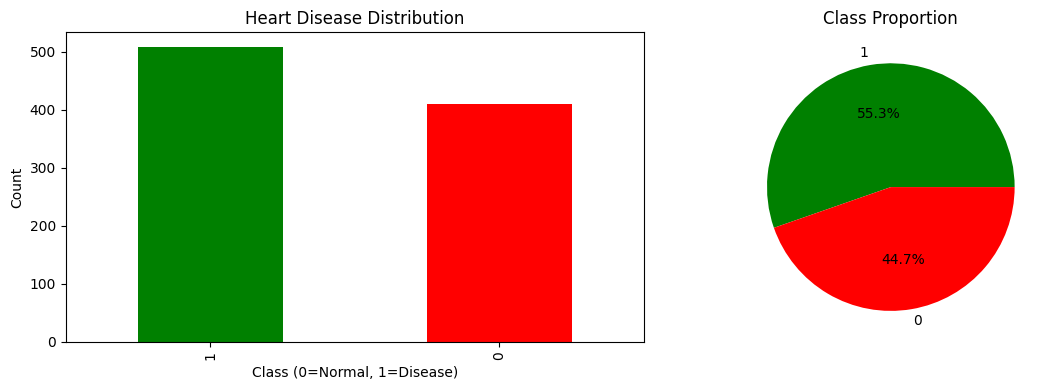

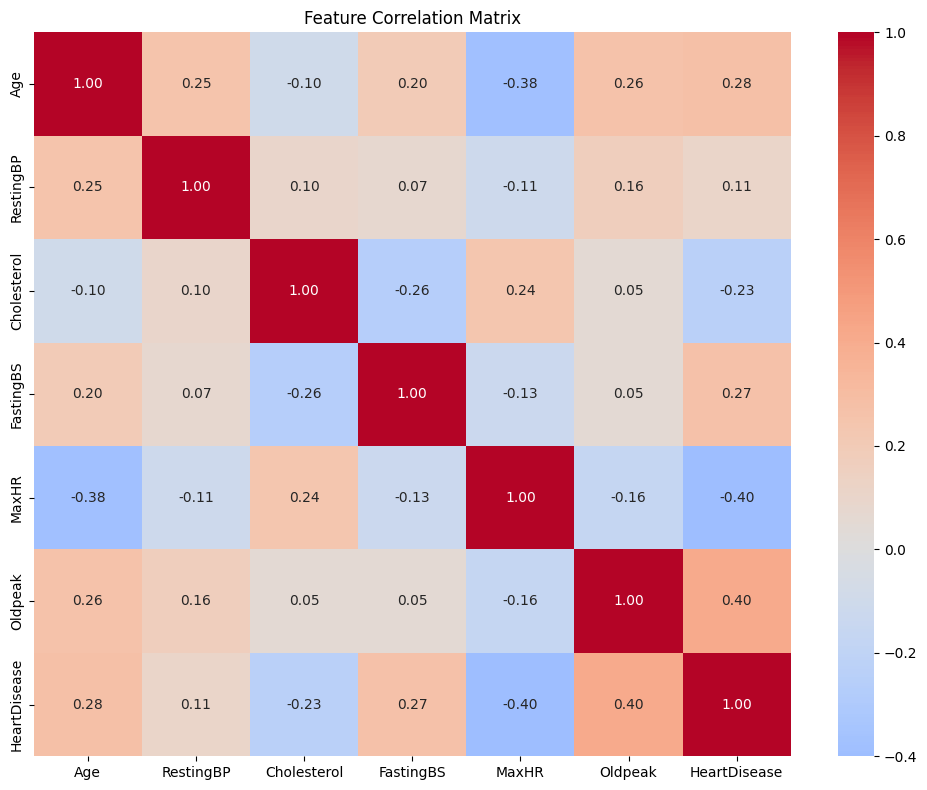

In [3]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Class distribution
df['HeartDisease'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Heart Disease Distribution')
axes[0].set_xlabel('Class (0=Normal, 1=Disease)')
axes[0].set_ylabel('Count')

# Pie chart
df['HeartDisease'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['green', 'red'])
axes[1].set_title('Class Proportion')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Correlation heatmap for numerical features
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Step 3: Data Preprocessing & Feature Encoding

In [4]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Encode categorical variables (LabelEncoder for binary/ordinal, pd.get_dummies for nominal)
df_processed = df.copy()

# Encode Sex (M/F -> 1/0)
df_processed['Sex'] = LabelEncoder().fit_transform(df_processed['Sex'])

# For other categorical features, use LabelEncoder
for col in ['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']:
    if col in df_processed.columns:
        df_processed[col] = LabelEncoder().fit_transform(df_processed[col])

print("\nProcessed Dataset (first 5 rows):")
print(df_processed.head())

# Separate features and target
X = df_processed.drop('HeartDisease', axis=1)
y = df_processed['HeartDisease']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names: {list(X.columns)}")

Categorical columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Numerical columns: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']

Processed Dataset (first 5 rows):
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    1              1        140          289          0           1   
1   49    0              2        160          180          0           1   
2   37    1              1        130          283          0           2   
3   48    0              0        138          214          0           1   
4   54    1              2        150          195          0           1   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         2             0  
1    156               0      1.0         1             1  
2     98               0      0.0         2             0  
3    108               1      1.5         1             1  
4    122

## Step 4: Train-Test Split & Feature Scaling

In [5]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Train target distribution:\n{y_train.value_counts()}")
print(f"\nTest target distribution:\n{y_test.value_counts()}")

# Feature Scaling (CRITICAL for SVM!)
# SVM is distance-based, so scaling is essential
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on train, transform train
X_test_scaled = scaler.transform(X_test)        # Use same scaler for test (prevent data leakage)

print(f"\nScaling verification:")
print(f"Train mean: {X_train_scaled.mean(axis=0)[:3]}...")  # Should be ~0
print(f"Train std: {X_train_scaled.std(axis=0)[:3]}...")   # Should be ~1
print(f"\n✓ Data split and scaled successfully!")

Training set size: 734
Testing set size: 184
Train target distribution:
HeartDisease
1    406
0    328
Name: count, dtype: int64

Test target distribution:
HeartDisease
1    102
0     82
Name: count, dtype: int64

Scaling verification:
Train mean: [ 2.10549108e-16 -9.43840827e-17  3.38814656e-17]...
Train std: [1. 1. 1.]...

✓ Data split and scaled successfully!


## Step 5: Train SVM with Different Kernels

In [6]:
# Train SVM models with different kernels
# SVM Kernels: linear, rbf (Radial Basis Function), poly (polynomial)

kernels = ['linear', 'rbf', 'poly']
svm_models = {}

print("Training SVM with different kernels...\n")

for kernel in kernels:
    print(f"Training SVM with {kernel} kernel...")
    model = SVC(kernel=kernel, probability=True, random_state=42)
    model.fit(X_train_scaled, y_train)
    svm_models[kernel] = model
    
    # Quick evaluation
    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy:  {test_acc:.4f}\n")

print("✓ All SVM models trained successfully!")

Training SVM with different kernels...

Training SVM with linear kernel...
  Train Accuracy: 0.8569
  Test Accuracy:  0.8696

Training SVM with rbf kernel...
  Train Accuracy: 0.9074
  Test Accuracy:  0.8859

Training SVM with poly kernel...
  Train Accuracy: 0.9060
  Test Accuracy:  0.8913

✓ All SVM models trained successfully!


## Step 6: Hyperparameter Tuning with GridSearchCV

In [7]:
# GridSearchCV to find best hyperparameters
print("Performing GridSearchCV for hyperparameter tuning...\n")

param_grid = {
    'C': [0.1, 1, 10, 100],           # Regularization parameter
    'kernel': ['linear', 'rbf'],      # Kernel type
    'gamma': ['scale', 'auto', 0.001, 0.01]  # Kernel coefficient (for rbf)
}

svm_grid = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(svm_grid, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Val Score: {grid_search.best_score_:.4f}")
print(f"\nBest SVM Model created with optimized hyperparameters")

# Use the best model
best_svm = grid_search.best_estimator_
print(f"✓ Best model selected from grid search!")

Performing GridSearchCV for hyperparameter tuning...

Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best Cross-Val Score: 0.8624

Best SVM Model created with optimized hyperparameters
✓ Best model selected from grid search!
Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best Cross-Val Score: 0.8624

Best SVM Model created with optimized hyperparameters
✓ Best model selected from grid search!


## Step 7: Comprehensive Model Evaluation

In [8]:
# Make predictions using the best SVM model
y_pred_train = best_svm.predict(X_train_scaled)
y_pred_test = best_svm.predict(X_test_scaled)

# Get prediction probabilities for ROC-AUC
y_pred_proba_test = best_svm.predict_proba(X_test_scaled)[:, 1]

# === EVALUATION METRICS ===
print("="*70)
print("MODEL EVALUATION METRICS - BEST SVM")
print("="*70)

# 1. Accuracy
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"\n1. ACCURACY")
print(f"   Training Accuracy:  {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"   Testing Accuracy:   {test_acc:.4f} ({test_acc*100:.2f}%)")

# 2. Precision
train_prec = precision_score(y_train, y_pred_train)
test_prec = precision_score(y_test, y_pred_test)
print(f"\n2. PRECISION (True Positives / Predicted Positives)")
print(f"   Training Precision: {train_prec:.4f}")
print(f"   Testing Precision:  {test_prec:.4f}")
print(f"   → Out of predicted heart disease cases, {test_prec*100:.2f}% are actually positive")

# 3. Recall (Sensitivity)
train_recall = recall_score(y_train, y_pred_train)
test_recall = recall_score(y_test, y_pred_test)
print(f"\n3. RECALL/SENSITIVITY (True Positives / Actual Positives)")
print(f"   Training Recall:    {train_recall:.4f}")
print(f"   Testing Recall:     {test_recall:.4f}")
print(f"   → Model detects {test_recall*100:.2f}% of actual heart disease cases")

# 4. F1-Score (harmonic mean of precision and recall)
train_f1 = f1_score(y_train, y_pred_train)
test_f1 = f1_score(y_test, y_pred_test)
print(f"\n4. F1-SCORE (Balance between Precision and Recall)")
print(f"   Training F1-Score:  {train_f1:.4f}")
print(f"   Testing F1-Score:   {test_f1:.4f}")

# 5. ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba_test)
print(f"\n5. ROC-AUC SCORE (Area Under ROC Curve)")
print(f"   ROC-AUC:            {roc_auc:.4f}")
print(f"   → Model's ability to distinguish between classes: {roc_auc*100:.2f}%")

print("\n" + "="*70)

MODEL EVALUATION METRICS - BEST SVM

1. ACCURACY
   Training Accuracy:  0.8787 (87.87%)
   Testing Accuracy:   0.8641 (86.41%)

2. PRECISION (True Positives / Predicted Positives)
   Training Precision: 0.8729
   Testing Precision:  0.8667
   → Out of predicted heart disease cases, 86.67% are actually positive

3. RECALL/SENSITIVITY (True Positives / Actual Positives)
   Training Recall:    0.9138
   Testing Recall:     0.8922
   → Model detects 89.22% of actual heart disease cases

4. F1-SCORE (Balance between Precision and Recall)
   Training F1-Score:  0.8929
   Testing F1-Score:   0.8792

5. ROC-AUC SCORE (Area Under ROC Curve)
   ROC-AUC:            0.9093
   → Model's ability to distinguish between classes: 90.93%



## Confusion Matrix & Classification Report

Confusion Matrix on Test Set:
[[68 14]
 [11 91]]

Interpretation:
  True Negatives (TN):   68 - Correctly predicted normal
  False Positives (FP):  14 - Normal predicted as disease (Type I error)
  False Negatives (FN):  11 - Disease predicted as normal (Type II error - CRITICAL!)
  True Positives (TP):   91 - Correctly predicted disease

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal       0.86      0.83      0.84        82
     Disease       0.87      0.89      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



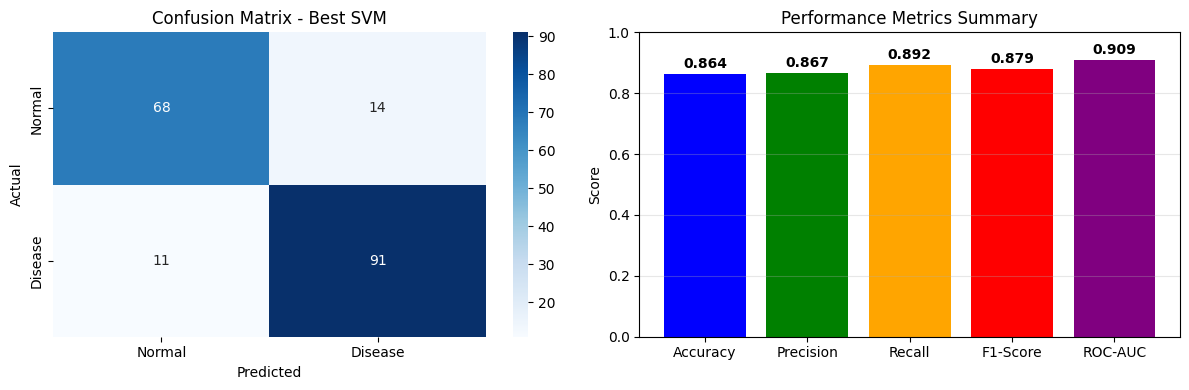

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix on Test Set:")
print(cm)
print(f"\nInterpretation:")
print(f"  True Negatives (TN):   {cm[0,0]} - Correctly predicted normal")
print(f"  False Positives (FP):  {cm[0,1]} - Normal predicted as disease (Type I error)")
print(f"  False Negatives (FN):  {cm[1,0]} - Disease predicted as normal (Type II error - CRITICAL!)")
print(f"  True Positives (TP):   {cm[1,1]} - Correctly predicted disease")

# Visualize Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Normal', 'Disease'], yticklabels=['Normal', 'Disease'])
axes[0].set_title('Confusion Matrix - Best SVM')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Classification Report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
report = classification_report(y_test, y_pred_test, target_names=['Normal', 'Disease'])
print(report)

# Plot metrics
metrics_data = {
    'Accuracy': test_acc,
    'Precision': test_prec,
    'Recall': test_recall,
    'F1-Score': test_f1,
    'ROC-AUC': roc_auc
}

axes[1].bar(metrics_data.keys(), metrics_data.values(), color=['blue', 'green', 'orange', 'red', 'purple'])
axes[1].set_title('Performance Metrics Summary')
axes[1].set_ylabel('Score')
axes[1].set_ylim([0, 1])
for i, (k, v) in enumerate(metrics_data.items()):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## ROC Curve & AUC Analysis

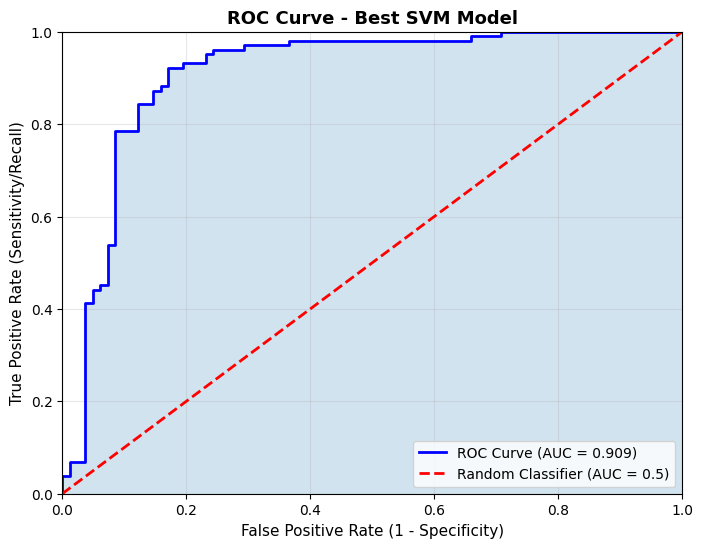

ROC Curve Interpretation:
- AUC Score: 0.9093
- Closer to 1.0 = better model (perfect separation)
- Closer to 0.5 = random guessing
- Our model AUC: Excellent


In [10]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier (AUC = 0.5)')
plt.fill_between(fpr, tpr, alpha=0.2)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=11)
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=11)
plt.title('ROC Curve - Best SVM Model', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

print("ROC Curve Interpretation:")
print(f"- AUC Score: {roc_auc:.4f}")
print(f"- Closer to 1.0 = better model (perfect separation)")
print(f"- Closer to 0.5 = random guessing")
print(f"- Our model AUC: {'Excellent' if roc_auc > 0.9 else 'Good' if roc_auc > 0.8 else 'Acceptable' if roc_auc > 0.7 else 'Poor'}")

## Comparison of SVM Kernels


SVM KERNEL COMPARISON ON TEST SET
Kernel  Accuracy  Precision   Recall  F1-Score  ROC-AUC
linear  0.869565   0.848214 0.931373  0.887850 0.890842
   rbf  0.885870   0.864865 0.941176  0.901408 0.928623
  poly  0.891304   0.894231 0.911765  0.902913 0.897657


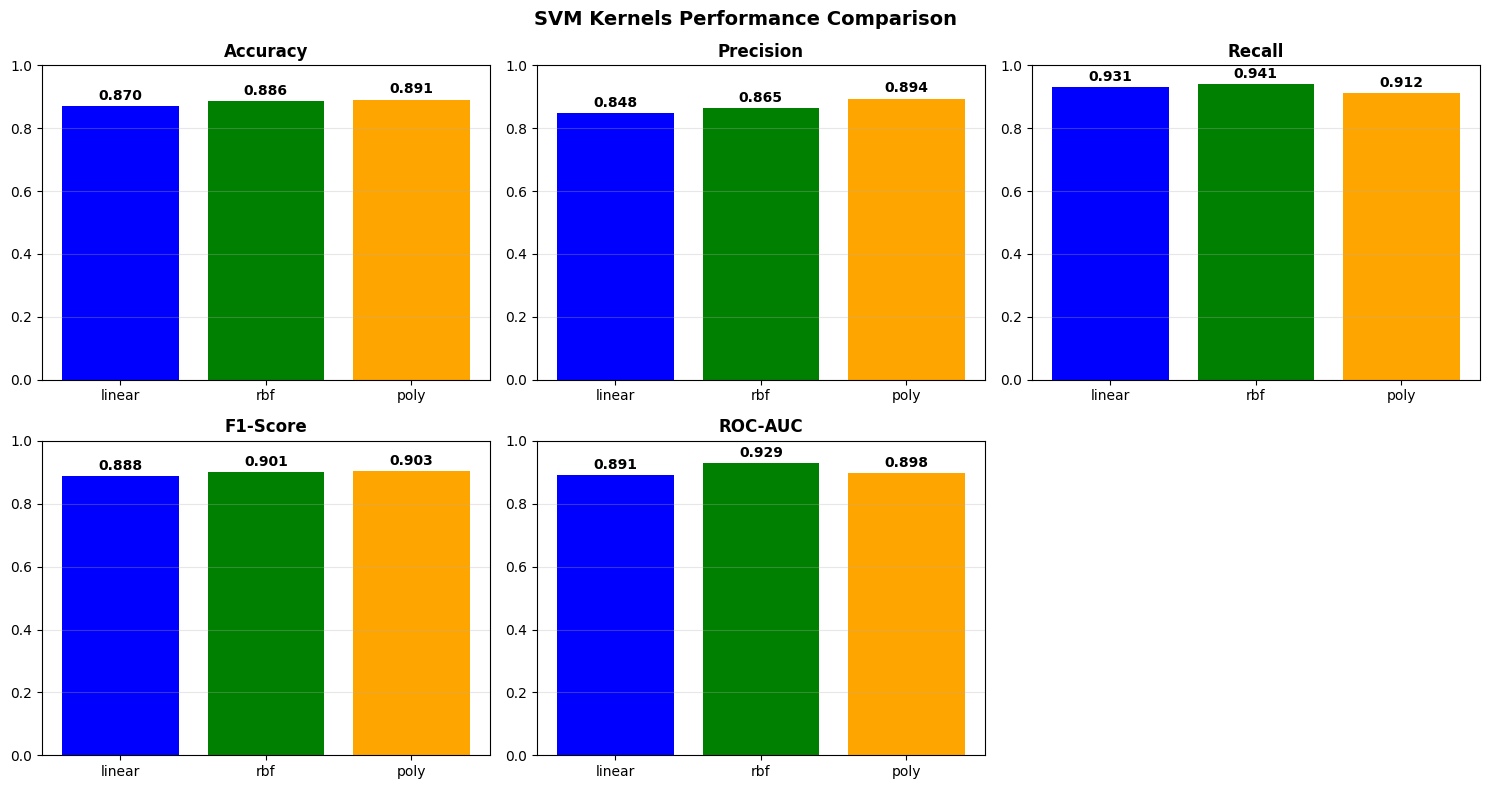

In [11]:
# Compare all kernel types
comparison_results = []

for kernel in kernels:
    model = svm_models[kernel]
    y_pred_k = model.predict(X_test_scaled)
    y_pred_proba_k = model.predict_proba(X_test_scaled)[:, 1]
    
    results = {
        'Kernel': kernel,
        'Accuracy': accuracy_score(y_test, y_pred_k),
        'Precision': precision_score(y_test, y_pred_k),
        'Recall': recall_score(y_test, y_pred_k),
        'F1-Score': f1_score(y_test, y_pred_k),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_k)
    }
    comparison_results.append(results)

comparison_df = pd.DataFrame(comparison_results)
print("\n" + "="*80)
print("SVM KERNEL COMPARISON ON TEST SET")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('SVM Kernels Performance Comparison', fontsize=14, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    values = comparison_df[metric].values
    ax.bar(kernels, values, color=['blue', 'green', 'orange'])
    ax.set_title(metric, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Remove extra subplot
axes[1, 2].remove()

plt.tight_layout()
plt.show()